In [509]:
import pandas as pd
import numpy as np
import folium
import warnings
from matplotlib import pyplot as plt
import re
import json
import platform
%matplotlib inline
if platform.system() == 'Windows':
    plt.rc('font', family='Malgun Gothic')


In [510]:
# 데이터 출처 : http://data.seoul.go.kr/dataList/5/literacyView.do
# 서울특별시 공공자전거 대여소 정보
df = pd.read_csv('bikeInfo_20200713.csv')

In [511]:
# 데이터 출처 : http://data.seoul.go.kr/dataList/412/S/2/datasetView.do
# 서울시 행정구역별 통계 (면적 참조용)
area = pd.read_csv('report.txt', sep = '\t', skiprows=[0,2])

In [512]:
area.head()

기간  자치구     면적  구성비(%)  행정  법정    통      반
0  2019  종로구  23.91     4.0  17  87  278  1,479
1  2019   중구   9.96     1.6  15  74  253  1,580
2  2019  용산구  21.87     3.6  16  36  351  2,550
3  2019  성동구  16.86     2.8  17  17  466  3,619
4  2019  광진구  17.06     2.8  15   7  363  2,999

In [513]:
area.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25 entries, 0 to 24
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   기간      25 non-null     int64  
 1   자치구     25 non-null     object 
 2   면적      25 non-null     float64
 3   구성비(%)  25 non-null     float64
 4   행정      25 non-null     int64  
 5   법정      25 non-null     int64  
 6   통       25 non-null     int64  
 7   반       25 non-null     object 
dtypes: float64(2), int64(4), object(2)
memory usage: 1.7+ KB


In [514]:
df = df.drop([2083])
df.isnull().sum()

대여소번호           0
보관소명            0
자치구             0
상세주소            0
위도              0
경도              0
설치시기            0
거치대수(LCD)     552
거치대수(QR)     1531
운영방식            0
dtype: int64

In [515]:
df.tail()

대여소번호          보관소명  자치구                  상세주소         위도          경도  \
2078  2547.0    포드서초서비스센터앞  서초구              잠원동 55-1  37.519047  127.012283   
2079  1573.0     현대성우아파트 옆  강북구            미아동 670-33  37.616665  127.022110   
2080  1268.0  몽촌토성역 1번출구 옆  송파구  서울특별시 송파구 방이동 88-21   37.517288  127.114197   
2081  1267.0   올림픽공원 남2문 앞  송파구    서울특별시 송파구 올림픽로 424  37.514240  127.123070   
2082   583.0    청계천 생태교실 앞  성동구   서울특별시 성동구 마장로39길 51  37.567970  127.046890   

            설치시기  거치대수(LCD)  거치대수(QR) 운영방식  
2078  2020-05-28        NaN      10.0   QR  
2079  2020-05-05        NaN      10.0   QR  
2080  2020-06-25        NaN      15.0   QR  
2081  2020-06-25        NaN      15.0   QR  
2082  2020-06-30        NaN       5.0   QR

In [516]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2083 entries, 0 to 2082
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   대여소번호      2083 non-null   float64
 1   보관소명       2083 non-null   object 
 2   자치구        2083 non-null   object 
 3   상세주소       2083 non-null   object 
 4   위도         2083 non-null   float64
 5   경도         2083 non-null   float64
 6   설치시기       2083 non-null   object 
 7   거치대수(LCD)  1531 non-null   float64
 8   거치대수(QR)   552 non-null    float64
 9   운영방식       2083 non-null   object 
dtypes: float64(5), object(5)
memory usage: 179.0+ KB


### 서울 구별 거치대 개수

In [517]:
station_by_city = df.groupby(['자치구'])[['거치대수(LCD)','거치대수(QR)']].sum()
area_by_city = area.groupby(['자치구'])[['면적']].sum()

In [518]:
station_by_city.head()

거치대수(LCD)  거치대수(QR)
자치구                     
강남구     1242.0     240.0
강동구      762.0     390.0
강북구      450.0     191.0
강서구     1021.0     735.0
관악구      627.0     207.0

In [519]:
area_by_city.head()

면적
자치구       
강남구  39.50
강동구  24.59
강북구  23.60
강서구  41.44
관악구  29.57

In [520]:
station_by_city['총거치대수'] = station_by_city['거치대수(LCD)'] + station_by_city['거치대수(QR)']
station_by_city['면적(km^2)'] = area_by_city['면적']
station_by_city['면적 대비 거치대 수 (개 / km^2)'] = station_by_city['총거치대수'] / station_by_city['면적(km^2)']
station_by_city.head()

거치대수(LCD)  거치대수(QR)   총거치대수  면적(km^2)  면적 대비 거치대 수 (개 / km^2)
자치구                                                               
강남구     1242.0     240.0  1482.0     39.50               37.518987
강동구      762.0     390.0  1152.0     24.59               46.848312
강북구      450.0     191.0   641.0     23.60               27.161017
강서구     1021.0     735.0  1756.0     41.44               42.374517
관악구      627.0     207.0   834.0     29.57               28.204261

In [521]:
station_by_city.sort_values("총거치대수",ascending=False).head()

거치대수(LCD)  거치대수(QR)   총거치대수  면적(km^2)  면적 대비 거치대 수 (개 / km^2)
자치구                                                                
송파구      1260.0     505.0  1765.0     33.87               52.111013
강서구      1021.0     735.0  1756.0     41.44               42.374517
서초구      1218.0     413.0  1631.0     46.98               34.716901
영등포구     1231.0     254.0  1485.0     24.55               60.488798
강남구      1242.0     240.0  1482.0     39.50               37.518987

In [522]:
station_by_city.sort_values("면적 대비 거치대 수 (개 / km^2)",ascending=False).head()

거치대수(LCD)  거치대수(QR)   총거치대수  면적(km^2)  면적 대비 거치대 수 (개 / km^2)
자치구                                                                
중구        478.0     387.0   865.0      9.96               86.847390
동대문구      659.0     227.0   886.0     14.22               62.306610
광진구       858.0     192.0  1050.0     17.06               61.547479
영등포구     1231.0     254.0  1485.0     24.55               60.488798
양천구       677.0     353.0  1030.0     17.41               59.161401

## 서울특별시 구별 총 거치대 수 점 분포도

In [523]:
map = folium.Map(location=[df['위도'].mean(), df['경도'].mean()], zoom_start=11, tiles='openstreetmap')

for n in df.index:
    popup_name = df['자치구'][n] + ' - ' + df['보관소명'][n]
    
    folium.CircleMarker(
        location=[df['위도'][n], df['경도'][n]],
        radius=1,
        popup=popup_name,
        fill=True,
    ).add_to(map)
    
map

## 서울특별시 구별 총 거치대 수 분포도

In [524]:
warnings.simplefilter(action = "ignore", category = FutureWarning)

# 참조 데이터 : https://github.com/southkorea/southkorea-maps
geo_path = 'skorea_municipalities_geo_simple.json'
geo_str = json.load(open(geo_path, encoding='utf-8'))
map = folium.Map(location=[37.55, 126.98], zoom_start=11, tiles='openstreetmap')

map.choropleth(
    geo_data = geo_str,
    data = station_by_city['총거치대수'],
    columns = [station_by_city.index,station_by_city['총거치대수']],
               fill_color = 'YlGn',
               key_on = 'properties.name')

In [525]:
map

## 서울특별시 구별 면적 대비 거치대 수 분포도

In [526]:
geo_path = 'skorea_municipalities_geo_simple.json'
geo_str = json.load(open(geo_path, encoding='utf-8'))
map = folium.Map(location=[37.55, 126.98], zoom_start=11, tiles='openstreetmap')

map.choropleth(
    geo_data = geo_str,
    data = station_by_city['면적 대비 거치대 수 (개 / km^2)'],
    columns = [station_by_city.index,station_by_city['면적 대비 거치대 수 (개 / km^2)']],
               fill_color = 'YlGn',
               key_on = 'properties.name')
map

## 지역구별 거치대 수 막대그래프

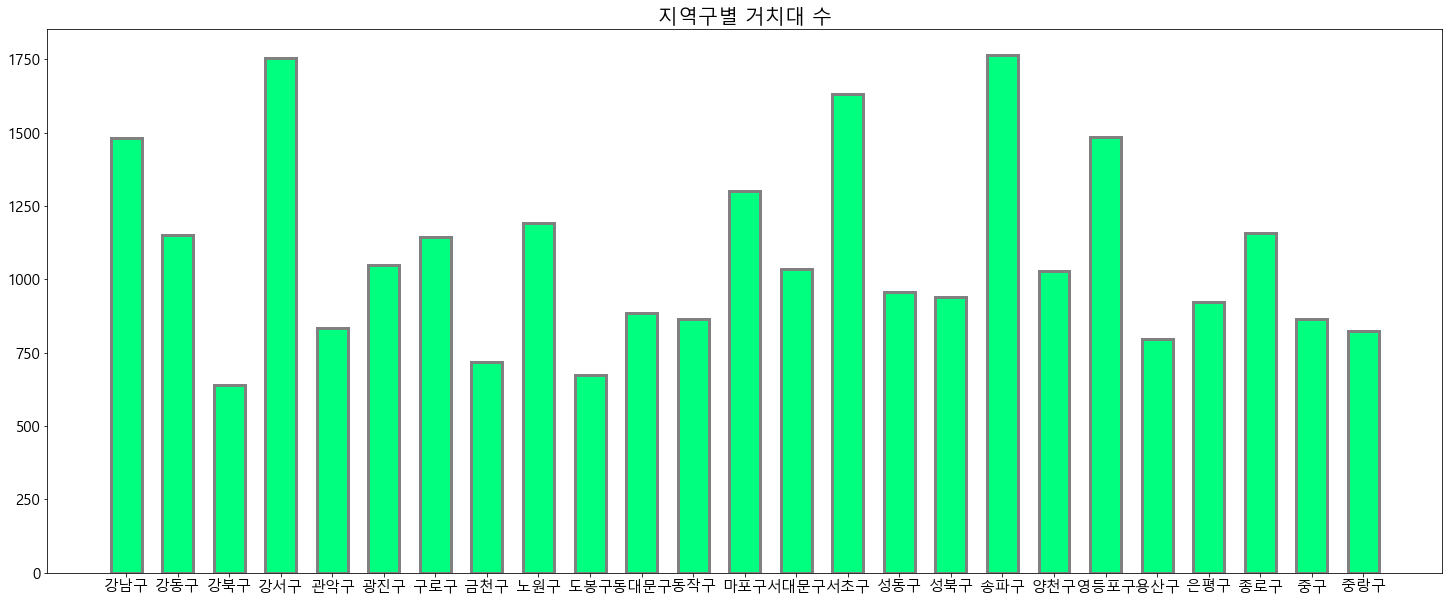

In [527]:
plt.figure(figsize=(25,10))
plt.title("지역구별 거치대 수", fontsize = 20)
plt.bar(station_by_city.index, station_by_city["총거치대수"], width=0.6, color="springgreen",
        edgecolor="gray", linewidth=3)
#linewidth=3, 
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

## 지역구별 면적 대비 거치대 수 (개 / km^2) 막대 그래프

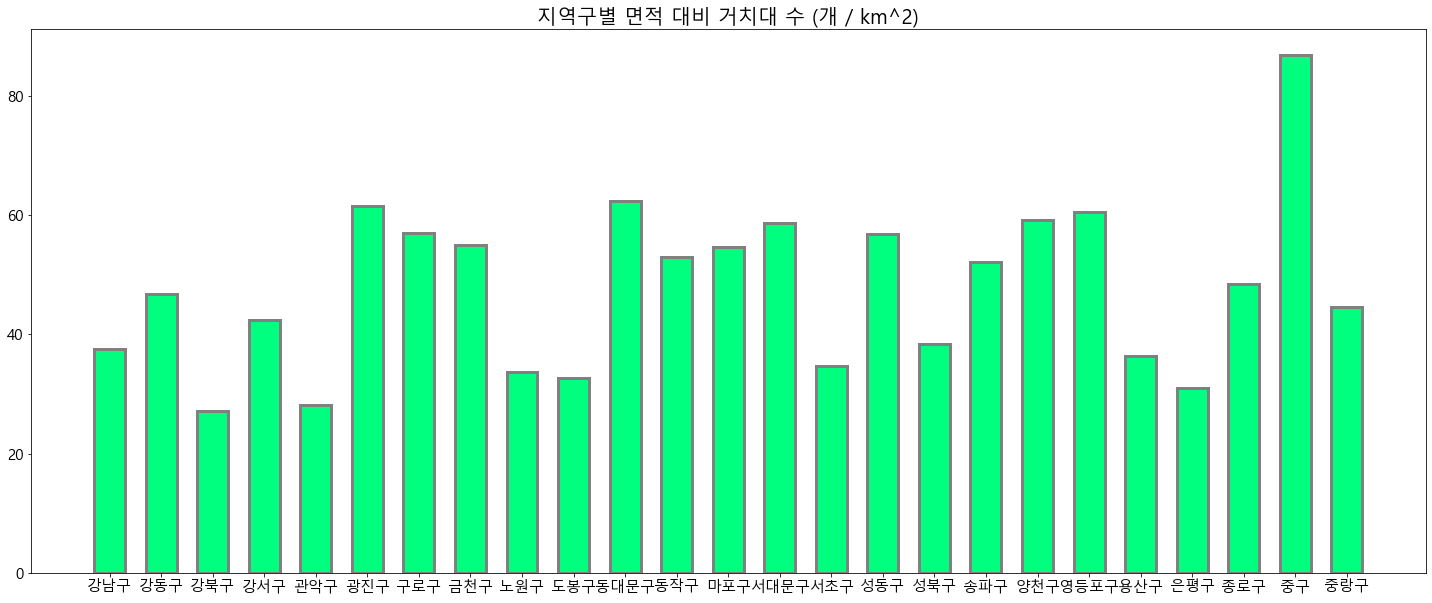

In [528]:
plt.figure(figsize=(25,10))
plt.title("지역구별 면적 대비 거치대 수 (개 / km^2)", fontsize = 20)
plt.bar(station_by_city.index, station_by_city["면적 대비 거치대 수 (개 / km^2)"], width=0.6, color="springgreen",
        edgecolor="gray", linewidth=3)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

# 거치대 수가 많을수록 자전거 사용량이 많을까?

In [529]:
# 서울특별시 공공자전거 이용정보(월별) http://data.seoul.go.kr/dataList/OA-15248/F/1/datasetView.do
monRental = pd.read_csv('monthly_RentalInfo_20-01_20-05.csv', skiprows=[1,2,3,4,5])

In [530]:
monRental.head()

대여일자  대여소번호              대여소명   대여구분코드   성별    연령대코드  이용건수      운동량  \
0  20-Jan    101  101. (구)합정동 주민센터  일일(비회원)   \N  AGE_008     2   341.31   
1  20-Jan    101  101. (구)합정동 주민센터   일일(회원)   \N  AGE_002    15  1084.68   
2  20-Jan    101  101. (구)합정동 주민센터   일일(회원)   \N  AGE_003     5   405.08   
3  20-Jan    101  101. (구)합정동 주민센터   일일(회원)  NaN  AGE_002     1   280.27   
4  20-Jan    101  101. (구)합정동 주민센터   일일(회원)  NaN  AGE_003     1    72.82   

    탄소량     이동거리  이용시간  
0  3.07  13260.0   121  
1  9.74  41990.0   382  
2  4.32  18620.0   117  
3  1.73   7450.0    35  
4   0.6   2590.0    40

In [531]:
monRental['대여소번호'] = monRental['대여소번호'].astype(str)
df['대여소번호'] = df['대여소번호'].astype(int)
#pd.to_numeric(df['대여소번호'], downcast='integer')
df['대여소번호'] = df['대여소번호'].astype(str)

In [532]:
monRental.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 327226 entries, 0 to 327225
Data columns (total 11 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   대여일자    327226 non-null  object 
 1   대여소번호   327226 non-null  object 
 2   대여소명    327226 non-null  object 
 3   대여구분코드  327226 non-null  object 
 4   성별      272836 non-null  object 
 5   연령대코드   327226 non-null  object 
 6   이용건수    327226 non-null  int64  
 7   운동량     327226 non-null  object 
 8   탄소량     327226 non-null  object 
 9   이동거리    327226 non-null  float64
 10  이용시간    327226 non-null  int64  
dtypes: float64(1), int64(2), object(8)
memory usage: 27.5+ MB


In [533]:
df.head()

대여소번호                      보관소명  자치구                   상세주소         위도  \
0  1695                월계미륭아파트 정문  노원구            노원구 월계동 14   37.623417   
1  2301                현대고등학교 건너편  강남구     서울특별시 강남구 압구정로 134  37.524071   
2  2302  교보타워 버스정류장(신논현역 3번출구 후면)  강남구  서울특별시 강남구 봉은사로 지하 102  37.505581   
3  2303                  논현역 7번출구  강남구   서울특별시 강남구 학동로 지하 102  37.511517   
4  2304         신영 ROYAL PALACE 앞  강남구      서울특별시 강남구 언주로 626  37.512527   

           경도        설치시기  거치대수(LCD)  거치대수(QR) 운영방식  
0  127.066933  2020-06-17        NaN      10.0   QR  
1  127.021790  2017-06-13       10.0       NaN  LCD  
2  127.024277  2017-06-13       10.0       NaN  LCD  
3  127.021477  2017-06-13       15.0       NaN  LCD  
4  127.035835  2017-06-13       10.0       NaN  LCD

In [534]:
mergedResult = pd.merge(monRental, df, on=['대여소번호'], how='left')
mergedResult.head()

대여일자 대여소번호              대여소명   대여구분코드   성별    연령대코드  이용건수      운동량   탄소량  \
0  20-Jan   101  101. (구)합정동 주민센터  일일(비회원)   \N  AGE_008     2   341.31  3.07   
1  20-Jan   101  101. (구)합정동 주민센터   일일(회원)   \N  AGE_002    15  1084.68  9.74   
2  20-Jan   101  101. (구)합정동 주민센터   일일(회원)   \N  AGE_003     5   405.08  4.32   
3  20-Jan   101  101. (구)합정동 주민센터   일일(회원)  NaN  AGE_002     1   280.27  1.73   
4  20-Jan   101  101. (구)합정동 주민센터   일일(회원)  NaN  AGE_003     1    72.82   0.6   

      이동거리  이용시간         보관소명  자치구                상세주소         위도          경도  \
0  13260.0   121  (구)합정동 주민센터  마포구  서울특별시 마포구 동교로8길 58  37.549561  126.905754   
1  41990.0   382  (구)합정동 주민센터  마포구  서울특별시 마포구 동교로8길 58  37.549561  126.905754   
2  18620.0   117  (구)합정동 주민센터  마포구  서울특별시 마포구 동교로8길 58  37.549561  126.905754   
3   7450.0    35  (구)합정동 주민센터  마포구  서울특별시 마포구 동교로8길 58  37.549561  126.905754   
4   2590.0    40  (구)합정동 주민센터  마포구  서울특별시 마포구 동교로8길 58  37.549561  126.905754   

         설치시기  거치대수(LCD)  거치대수(QR) 운영방식  
0  2015-09-06        5.0       NaN  LCD  
1  2015-09-06        5.0       NaN  LCD  
2  2015-09-06        5.0       NaN  LCD  
3  2015-09-06        5.0       NaN  LCD  
4  2015-09-06        5.0       NaN  LCD

### 지역구별 거치대수 대비 이용건수

In [535]:
loc_used_station = mergedResult.groupby(['자치구'])[['이용건수']].sum()
loc_used_station.head()

이용건수
자치구        
강남구  286225
강동구  291550
강북구  144167
강서구  545201
관악구  248687

In [536]:
loc_used_station['거치대수'] = station_by_city['총거치대수']

In [537]:
loc_used_station['이용건수 / 거치대 수'] = round(loc_used_station['이용건수'] / station_by_city['총거치대수'], 2)
loc_used_station['평균 거치대 대비 이용건수'] = loc_used_station['이용건수 / 거치대 수'].mean()
loc_used_station.head()

이용건수    거치대수  이용건수 / 거치대 수  평균 거치대 대비 이용건수
자치구                                              
강남구  286225  1482.0        193.13        277.3588
강동구  291550  1152.0        253.08        277.3588
강북구  144167   641.0        224.91        277.3588
강서구  545201  1756.0        310.48        277.3588
관악구  248687   834.0        298.19        277.3588

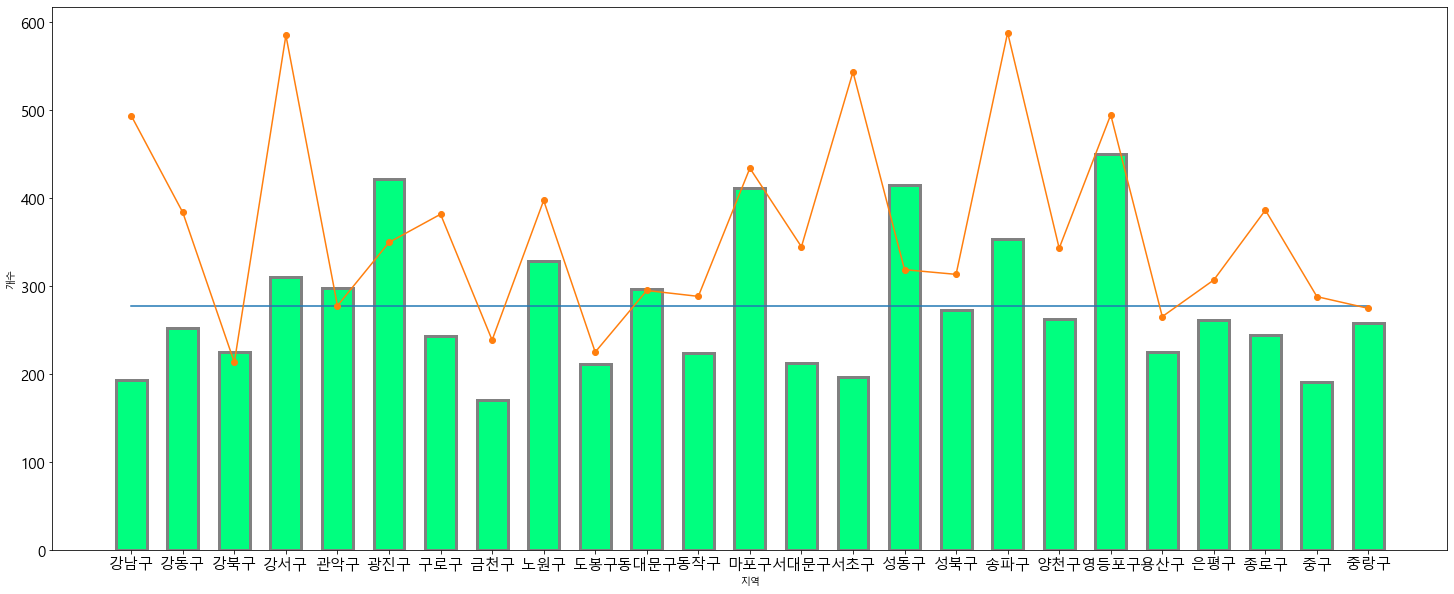

In [538]:
plt.figure(figsize=(25,10))

plt.subplot(111)
plt.bar(loc_used_station.index, loc_used_station["이용건수 / 거치대 수"], align='center', width=0.6, color="springgreen",
        edgecolor="gray", linewidth=3)
plt.plot(loc_used_station.index, loc_used_station['평균 거치대 대비 이용건수'])
plt.plot(loc_used_station.index, loc_used_station['거치대수']/3, marker='o')
plt.xlabel('지역')
plt.ylabel('개수')
# plt.xticks(np.linspace(9,endpoint=True))

# ax1 = ax2.twinx()

# ax1.set_ylabel('거치대 수')
# ax1.axes.get_xaxis().set_ticks([])
# ax1.tick_params(axis='x', bottom='off', labelbottom='off')
# plt.title("지역구별 거치대수 대비 이용건수 (이용건수 / 지역구 거치대 수)", fontsize = 20)
# plt.bar(loc_used_station.index, loc_used_station["이용건수 / 거치대 수"], width=0.6, color="springgreen",
#         edgecolor="gray", linewidth=3)



plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

In [539]:
corr = mergedResult.groupby(['대여소번호'])[['이용건수','거치대수(LCD)','거치대수(QR)']].sum()
corr = corr.drop(['10'])
corr.head()
# station_by_city = df.groupby(['자치구'])[['거치대수(LCD)','거치대수(QR)']].sum()


이용건수  거치대수(LCD)  거치대수(QR)
대여소번호                           
1001   8677     3584.0       0.0
1002   8273     2600.0       0.0
1003   3391     4480.0       0.0
1004   6185     2610.0       0.0
1006   3567     3255.0       0.0

In [540]:
corr['총거치대수'] = corr['거치대수(LCD)'] + corr['거치대수(QR)']
corr.head()
#corr.sort_values('총거치대수',ascending=False)

이용건수  거치대수(LCD)  거치대수(QR)   총거치대수
대여소번호                                   
1001   8677     3584.0       0.0  3584.0
1002   8273     2600.0       0.0  2600.0
1003   3391     4480.0       0.0  4480.0
1004   6185     2610.0       0.0  2610.0
1006   3567     3255.0       0.0  3255.0

## linear regression

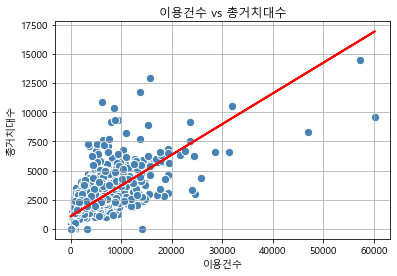

In [541]:
# plotting the model
X = corr[['이용건수']]
y = corr[['총거치대수']]

from sklearn.linear_model import LinearRegression

# training the model
lr = LinearRegression()
lr.fit(X,y)


plt.plot(X,lr.predict(X), color='red', lw=2)  

plt.scatter(corr['이용건수'].values, corr["총거치대수"].values, c="steelblue", edgecolor="white", s=70)
plt.title('이용건수 vs 총거치대수') 
plt.xlabel('이용건수') 
plt.ylabel('총거치대수') 
plt.grid()
plt.show()

In [542]:
from statsmodels.formula.api import ols

In [543]:
res=ols('이용건수~총거치대수',data=corr).fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   이용건수   R-squared:                       0.516
Model:                            OLS   Adj. R-squared:                  0.516
Method:                 Least Squares   F-statistic:                     2143.
Date:                Mon, 07 Dec 2020   Prob (F-statistic):          3.34e-319
Time:                        04:47:52   Log-Likelihood:                -19035.
No. Observations:                2014   AIC:                         3.807e+04
Df Residuals:                    2012   BIC:                         3.809e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -279.8416    112.530     -2.487      0.013    -500.530     -59.154
총거치대수          1.9601      0.042     46.296      0.000       1.877       2.043
==============================================================================
Omnibus:                     1536.675   Durbin-Watson:                   1.774
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            75959.822
Skew:                           3.109   Prob(JB):                         0.00
Kurtosis:                      32.437   Cond. No.                     4.36e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.36e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

No.Observations 개수를 통해 2014개의 데이터쌍을 가지고 회귀분석을 하였음.
MEDV와의 유의확률 P>|t|값을 살펴보면 0.013 으로 0.05보다
작은 값이 나오기 때문에 통계적으로 타당하고, 유의미한 값이라고 볼 수 있다.
또한 R-squared의 값이 0.516정도로 이용건수의 변동성을 총거치대수가 약 51.6%
정도로 설명할 수 있다고 표현할 수 있고,
총거치대수의 coef 값이 1.9601으로 총거치대수의 개수가 1 증가할때마다 이용건수의 예측값이  1.9601씩
늘어나는 분포를 가지고 있다고 해석할 수 있다.
표의 예측 y절편은 -279.8416가 되고, 
회귀분석 선형식은 이용건수 = 1.9601 * 총거치대수 - 279.8416 으로 구할 수 있다.

In [570]:
# 2015년 인구 정보
resident_population_org = pd.read_csv("상주인구.txt", sep="\t", thousands=',')

resident_population_org.head()

기간  자치구    상주인구    유입인구  유입인구.1  유입인구.2    유출인구  유출인구.1  유출인구.2    주간인구  \
0  2015  종로구  147607  285056  254624   30432   40535   34419    6116  392128   
1  2015   중구  118632  354301  330898   23403   30708   25872    4836  442225   
2  2015  용산구  211973  126855  111234   15621   68822   60184    8638  270006   
3  2015  성동구  283996  127077  103131   23946   99815   86960   12855  311258   
4  2015  광진구  349775  101401   73000   28401  127334  112672   14662  323842   

   주간인구지수  
0   265.7  
1   372.8  
2   127.4  
3   109.6  
4    92.6

In [545]:
resident_population = resident_population_org[['자치구', '상주인구', '유입인구', '주간인구', '유출인구']]

resident_population.head()

자치구    상주인구    유입인구    주간인구    유출인구
0  종로구  147607  285056  392128   40535
1   중구  118632  354301  442225   30708
2  용산구  211973  126855  270006   68822
3  성동구  283996  127077  311258   99815
4  광진구  349775  101401  323842  127334

In [546]:
loc_used_station2 = mergedResult.groupby(['자치구'])[['이용건수']].sum()
loc_used_station2.reset_index(inplace=True)
loc_used_station2

자치구    이용건수
0    강남구  286225
1    강동구  291550
2    강북구  144167
3    강서구  545201
4    관악구  248687
5    광진구  443133
6    구로구  279004
7    금천구  122362
8    노원구  392200
9    도봉구  142953
10  동대문구  263340
11   동작구  194485
12   마포구  536132
13  서대문구  220073
14   서초구  320815
15   성동구  397104
16   성북구  256580
17   송파구  623684
18   양천구  271035
19  영등포구  669058
20   용산구  179813
21   은평구  241093
22   종로구  283338
23    중구  165336
24   중랑구  212901

In [547]:
#mergedResult = pd.concat([resident_population, bicycle_rental_series], axis=1)
mergedResult2 = pd.merge(resident_population, loc_used_station2, on=['자치구'], how='left')
mergedResult2.head()

자치구    상주인구    유입인구    주간인구    유출인구    이용건수
0  종로구  147607  285056  392128   40535  283338
1   중구  118632  354301  442225   30708  165336
2  용산구  211973  126855  270006   68822  179813
3  성동구  283996  127077  311258   99815  397104
4  광진구  349775  101401  323842  127334  443133

In [548]:
mergedResult2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25 entries, 0 to 24
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   자치구     25 non-null     object
 1   상주인구    25 non-null     int64 
 2   유입인구    25 non-null     int64 
 3   주간인구    25 non-null     int64 
 4   유출인구    25 non-null     int64 
 5   이용건수    25 non-null     int64 
dtypes: int64(5), object(1)
memory usage: 1.4+ KB


In [549]:
mergedResult2['총 인구'] = mergedResult2['주간인구']
mergedResult2['인당대여횟수'] = mergedResult2['이용건수'] / mergedResult2['총 인구']
mergedResult2

자치구    상주인구    유입인구    주간인구    유출인구    이용건수    총 인구    인당대여횟수
0    종로구  147607  285056  392128   40535  283338  392128  0.722565
1     중구  118632  354301  442225   30708  165336  442225  0.373873
2    용산구  211973  126855  270006   68822  179813  270006  0.665959
3    성동구  283996  127077  311258   99815  397104  311258  1.275803
4    광진구  349775  101401  323842  127334  443133  323842  1.368362
5   동대문구  348131  137142  377950  107323  263340  377950  0.696759
6    중랑구  393901   49737  308410  135228  212901  308410  0.690318
7    성북구  443960  116454  410734  149680  256580  410734  0.624687
8    강북구  312563   43081  248493  107151  144167  248493  0.580165
9    도봉구  334142   40667  258585  116224  142953  258585  0.552828
10   노원구  552958   94612  468323  179247  392200  468323  0.837456
11   은평구  469192   42461  350029  161624  241093  350029  0.688780
12  서대문구  298025  133850  331427  100448  220073  331427  0.664017
13   마포구  368536  194120  439567  123089  536132  439567  1.219682
14   양천구  455584   67561  361483  161662  271035  361483  0.749786
15   강서구  558064  108882  484021  182925  545201  484021  1.126399
16   구로구  405428  159357  426337  138448  279004  426337  0.654421
17   금천구  225481  135190  288775   71896  122362  288775  0.423728
18  영등포구  357863  283249  522674  118438  669058  522674  1.280067
19   동작구  390678  102550  348046  145182  194485  348046  0.558791
20   관악구  493859   75951  387169  182641  248687  387169  0.642322
21   서초구  411771  303313  579442  135642  320815  579442  0.553662
22   강남구  529413  614213  995036  148590  286225  995036  0.287653
23   송파구  620433  169502  594309  195626  623684  594309  1.049427
24   강동구  434196   69947  363040  141103  291550  363040  0.803080

In [550]:
mergedResult2.sort_values("이용건수", ascending=False)


자치구    상주인구    유입인구    주간인구    유출인구    이용건수    총 인구    인당대여횟수
18  영등포구  357863  283249  522674  118438  669058  522674  1.280067
23   송파구  620433  169502  594309  195626  623684  594309  1.049427
15   강서구  558064  108882  484021  182925  545201  484021  1.126399
13   마포구  368536  194120  439567  123089  536132  439567  1.219682
4    광진구  349775  101401  323842  127334  443133  323842  1.368362
3    성동구  283996  127077  311258   99815  397104  311258  1.275803
10   노원구  552958   94612  468323  179247  392200  468323  0.837456
21   서초구  411771  303313  579442  135642  320815  579442  0.553662
24   강동구  434196   69947  363040  141103  291550  363040  0.803080
22   강남구  529413  614213  995036  148590  286225  995036  0.287653
0    종로구  147607  285056  392128   40535  283338  392128  0.722565
16   구로구  405428  159357  426337  138448  279004  426337  0.654421
14   양천구  455584   67561  361483  161662  271035  361483  0.749786
5   동대문구  348131  137142  377950  107323  263340  377950  0.696759
7    성북구  443960  116454  410734  149680  256580  410734  0.624687
20   관악구  493859   75951  387169  182641  248687  387169  0.642322
11   은평구  469192   42461  350029  161624  241093  350029  0.688780
12  서대문구  298025  133850  331427  100448  220073  331427  0.664017
6    중랑구  393901   49737  308410  135228  212901  308410  0.690318
19   동작구  390678  102550  348046  145182  194485  348046  0.558791
2    용산구  211973  126855  270006   68822  179813  270006  0.665959
1     중구  118632  354301  442225   30708  165336  442225  0.373873
8    강북구  312563   43081  248493  107151  144167  248493  0.580165
9    도봉구  334142   40667  258585  116224  142953  258585  0.552828
17   금천구  225481  135190  288775   71896  122362  288775  0.423728

In [551]:
# plt.rcParams["font.family"] = 'NanumGothicCoding'

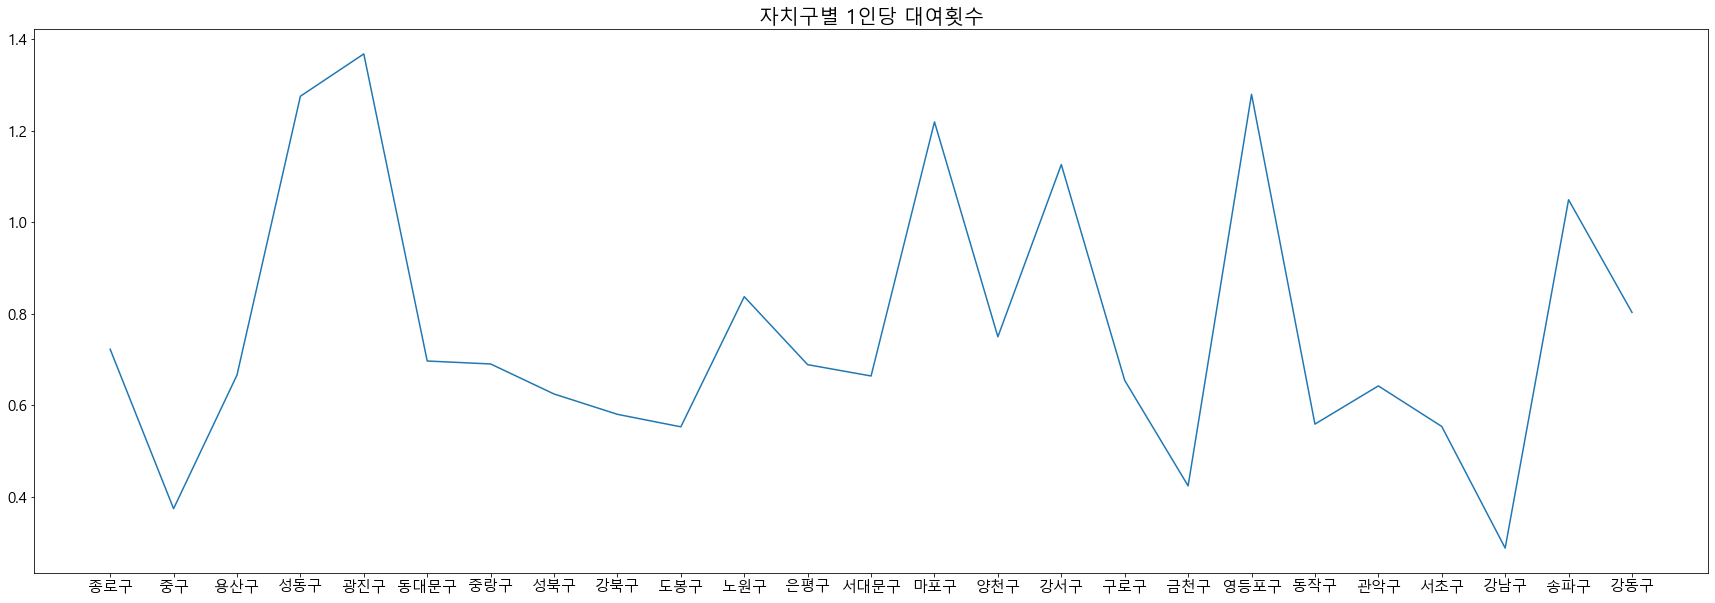

In [552]:
plt.figure(figsize=(30, 10))
plt.title("자치구별 1인당 대여횟수", fontsize = 20)
plt.plot(mergedResult2["자치구"], mergedResult2["인당대여횟수"])
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

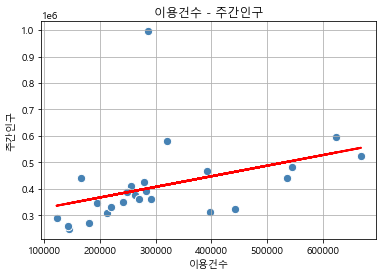

In [553]:
X = mergedResult2[['이용건수']]
y = mergedResult2[['주간인구']]

lr = LinearRegression()
lr.fit(X,y)

plt.plot(X,lr.predict(X), color='red', lw=2)  

plt.scatter(mergedResult2['이용건수'].values, mergedResult2["주간인구"].values, c="steelblue", edgecolor="white", s=70)
plt.title('이용건수 - 주간인구') 
plt.xlabel('이용건수') 
plt.ylabel('주간인구') 

'''
for i, txt in enumerate(mergedResult2['자치구']):
    plt.annotate(txt, (x[i], y[i]))
'''

plt.grid()
plt.show()

In [554]:
res=ols('이용건수~주간인구', data=mergedResult2).fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   이용건수   R-squared:                       0.155
Model:                            OLS   Adj. R-squared:                  0.119
Method:                 Least Squares   F-statistic:                     4.230
Date:                Mon, 07 Dec 2020   Prob (F-statistic):             0.0512
Time:                        04:47:53   Log-Likelihood:                -330.88
No. Observations:                  25   AIC:                             665.8
Df Residuals:                      23   BIC:                             668.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1.495e+05   8.26e+04      1.809      0.083   -2.14e+04     3.2e+05
주간인구           0.3883      0.189      2.057      0.051      -0.002       0.779
==============================================================================
Omnibus:                        3.000   Durbin-Watson:                   2.436
Prob(Omnibus):                  0.223   Jarque-Bera (JB):                2.286
Skew:                           0.737   Prob(JB):                        0.319
Kurtosis:                       2.841   Cond. No.                     1.28e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.28e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

C:\Users\Home\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\Home\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:183: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


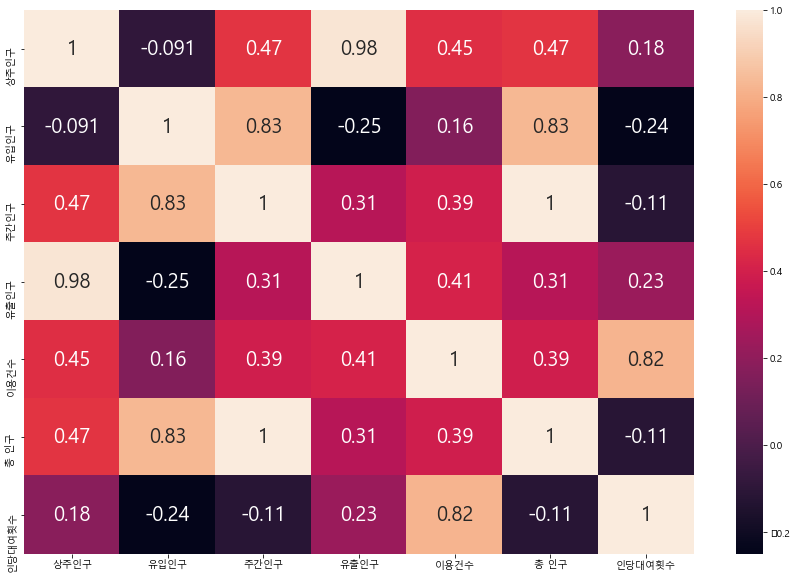

In [555]:
import seaborn as sns

corr = mergedResult2.corr()
plt.figure(figsize=(15,10))
sns.heatmap(corr, annot=True, annot_kws={"size" : 20})

In [ ]:
mergedResult2['상주인구'] /= 10000
mergedResult2['유입인구'] /= 10000
mergedResult2['유출인구'] /= 10000
mergedResult2['이용건수'] /= 10000

In [572]:
X = mergedResult2[['상주인구', '유입인구']]
y = mergedResult2[['이용건수']]

model = LinearRegression()
model.fit(X, y)

LinearRegression()

In [573]:
mergedResult2

자치구     상주인구     유입인구    주간인구     유출인구     이용건수    총 인구    인당대여횟수
0    종로구  14.7607  28.5056  392128   4.0535  28.3338  392128  0.722565
1     중구  11.8632  35.4301  442225   3.0708  16.5336  442225  0.373873
2    용산구  21.1973  12.6855  270006   6.8822  17.9813  270006  0.665959
3    성동구  28.3996  12.7077  311258   9.9815  39.7104  311258  1.275803
4    광진구  34.9775  10.1401  323842  12.7334  44.3133  323842  1.368362
5   동대문구  34.8131  13.7142  377950  10.7323  26.3340  377950  0.696759
6    중랑구  39.3901   4.9737  308410  13.5228  21.2901  308410  0.690318
7    성북구  44.3960  11.6454  410734  14.9680  25.6580  410734  0.624687
8    강북구  31.2563   4.3081  248493  10.7151  14.4167  248493  0.580165
9    도봉구  33.4142   4.0667  258585  11.6224  14.2953  258585  0.552828
10   노원구  55.2958   9.4612  468323  17.9247  39.2200  468323  0.837456
11   은평구  46.9192   4.2461  350029  16.1624  24.1093  350029  0.688780
12  서대문구  29.8025  13.3850  331427  10.0448  22.0073  331427  0.664017
13   마포구  36.8536  19.4120  439567  12.3089  53.6132  439567  1.219682
14   양천구  45.5584   6.7561  361483  16.1662  27.1035  361483  0.749786
15   강서구  55.8064  10.8882  484021  18.2925  54.5201  484021  1.126399
16   구로구  40.5428  15.9357  426337  13.8448  27.9004  426337  0.654421
17   금천구  22.5481  13.5190  288775   7.1896  12.2362  288775  0.423728
18  영등포구  35.7863  28.3249  522674  11.8438  66.9058  522674  1.280067
19   동작구  39.0678  10.2550  348046  14.5182  19.4485  348046  0.558791
20   관악구  49.3859   7.5951  387169  18.2641  24.8687  387169  0.642322
21   서초구  41.1771  30.3313  579442  13.5642  32.0815  579442  0.553662
22   강남구  52.9413  61.4213  995036  14.8590  28.6225  995036  0.287653
23   송파구  62.0433  16.9502  594309  19.5626  62.3684  594309  1.049427
24   강동구  43.4196   6.9947  363040  14.1103  29.1550  363040  0.803080

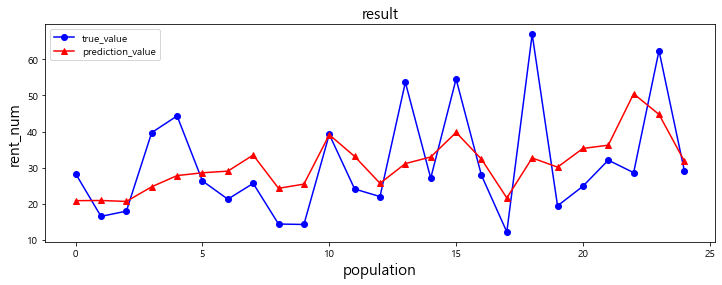

In [574]:
prediction = model.predict(X)

fig = plt.figure(figsize = (12, 4))
graph = fig.add_subplot(1, 1, 1)
graph.plot(y[:65], marker='o', color="blue", label="true_value")
graph.plot(prediction[:65], marker="^", color="red", label="prediction_value")
graph.set_title("result", size=15)
plt.xlabel('population', size=15)
plt.ylabel('rent_num', size=15)
plt.legend(loc='best')

[10.45930523]
1.2899543482052438
-2.2591069260258965
[[ 1.28995435 -2.25910693]]


C:\Users\Home\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\Home\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:183: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


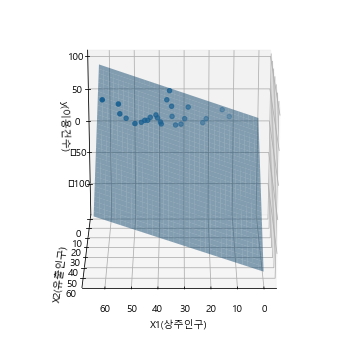

In [571]:
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(
    mergedResult2[['상주인구']], 
    mergedResult2[['유입인구']],
    #mergedResult2[['인당대여횟수']],
    mergedResult2[['이용건수']],
    marker='o', cmap='Greens'
)

ax.set_xlabel("X1(상주인구)")
ax.set_ylabel("X2(유입인구)")
ax.set_zlabel("y(이용건수)")

coefs = model.coef_
intercept = model.intercept_

print(intercept)
print(coefs[0][0])
print(coefs[0][1])
print(coefs)


'''print("Equation: y = {:.2f} + {:.2f}x1 + {:.2f}x2".
      format(intercept, coefs[0] ,coefs[1]))'''

num = 65
xs = np.tile(np.arange(num), (num,1))
ys = np.tile(np.arange(num), (num,1)).T
zs = xs*coefs[0][0] + ys*coefs[0][1] + intercept



ax.plot_surface(xs,ys,zs, alpha=0.5)

ax.view_init(21, 90)
plt.draw()

# for angle in range(0, 360):
#     ax.view_init(30, angle)
#     plt.draw()
#     plt.pause(.001)
#plt.show()

In [575]:
import statsmodels.api as sm
X = sm.add_constant(X, has_constant = "add")
res = sm.OLS(y, X)
res_fit = res.fit()
res_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   이용건수   R-squared:                       0.246
Model:                            OLS   Adj. R-squared:                  0.178
Method:                 Least Squares   F-statistic:                     3.591
Date:                Mon, 07 Dec 2020   Prob (F-statistic):             0.0447
Time:                        04:55:11   Log-Likelihood:                -99.200
No. Observations:                  25   AIC:                             204.4
Df Residuals:                      22   BIC:                             208.1
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.6199      9.832      0.572      0.573     -14.769      26.009
상주인구           0.5641      0.223      2.528      0.019       0.101       1.027
유입인구           0.2433      0.218      1.114      0.277      -0.209       0.696
==============================================================================
Omnibus:                        5.361   Durbin-Watson:                   2.352
Prob(Omnibus):                  0.069   Jarque-Bera (JB):                3.914
Skew:                           0.959   Prob(JB):                        0.141
Kurtosis:                       3.279   Cond. No.                         155.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""